In [195]:
# utilizando la libreria os para manejos de directorios
import os

# Computacion vectorial y cientifica para python
import numpy as np

#importamos pandas para el manejo del dataset, y separarlos dentro de una matriz
import pandas as pd

# Librerias para graficación (trazado de gráficos)
from matplotlib import pyplot
from mpl_toolkits.mplot3d import Axes3D  # -> Necesario para graficar superficies 3D

#Para separa el 20% y 80%
%pip install scikit-learn
from sklearn.model_selection import train_test_split

# llama a matplotlib a embeber graficas dentro de los cuadernillos
%matplotlib inline

Note: you may need to restart the kernel to use updated packages.



[notice] A new release of pip is available: 24.2 -> 25.2
[notice] To update, run: python.exe -m pip install --upgrade pip


In [196]:
df = pd.read_csv('seattleWeather_1948-2017.csv', delimiter=',')
df.head()

,DATE,PRCP,TMAX,TMIN,RAIN
0,1948-01-01,0.47,51,42,True
1,1948-01-02,0.59,45,36,True
2,1948-01-03,0.42,45,35,True
3,1948-01-04,0.31,45,34,True
4,1948-01-05,0.17,45,32,True


In [197]:
df["DATE"] = pd.to_datetime(df["DATE"], format="%Y-%m-%d")
df.set_index("DATE", inplace=True)


<Axes: xlabel='DATE'>

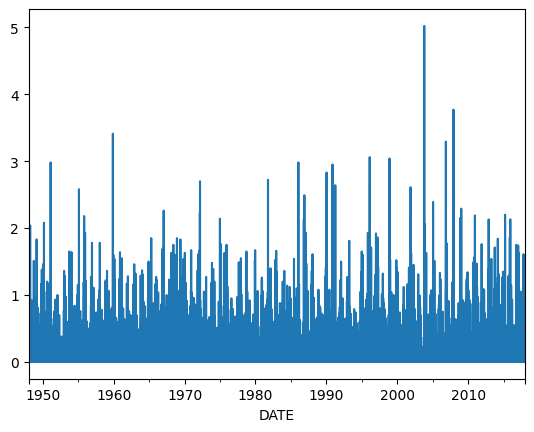

In [198]:
df["PRCP"].plot()

Creating a new dataset just for the Date and Close¶

In [199]:
import numpy as np

def create_sequences(values, n_steps):
    X, y = [], []
    for i in range(len(values) - n_steps):
        X.append(values[i:i+n_steps])
        y.append(values[i+n_steps])
    return np.array(X), np.array(y)

In [200]:
import numpy as np
from sklearn.preprocessing import MinMaxScaler

# 1. Extraer la serie de precipitación
values = df["PRCP"].values.reshape(-1, 1)

# Escalar los datos (opcional pero recomendado para RNN/LSTM)
scaler = MinMaxScaler()
values = scaler.fit_transform(values)

# 2. Crear secuencias (ventanas de n_steps)
def create_sequences(data, n_steps):
    X, y = [], []
    for i in range(len(data) - n_steps):
        X.append(data[i:i+n_steps])
        y.append(data[i+n_steps])  # el valor siguiente
    return np.array(X), np.array(y)

n_steps = 10  # igual que en la doc
X, y = create_sequences(values, n_steps)

print("Total X shape:", X.shape)
print("Total y shape:", y.shape)


Total X shape: (25541, 10, 1)
Total y shape: (25541, 1)


In [201]:
# Usar proporciones similares (70% train, 20% valid, 10% test)
train_size = int(len(X) * 0.7)
valid_size = int(len(X) * 0.2)

X_train, y_train = X[:train_size], y[:train_size]
X_valid, y_valid = X[train_size:train_size+valid_size], y[train_size:train_size+valid_size]
X_test, y_test   = X[train_size+valid_size:], y[train_size+valid_size:]

print("Train:", X_train.shape, y_train.shape)
print("Valid:", X_valid.shape, y_valid.shape)
print("Test:", X_test.shape, y_test.shape)


Train: (17878, 10, 1) (17878, 1)
Valid: (5108, 10, 1) (5108, 1)
Test: (2555, 10, 1) (2555, 1)


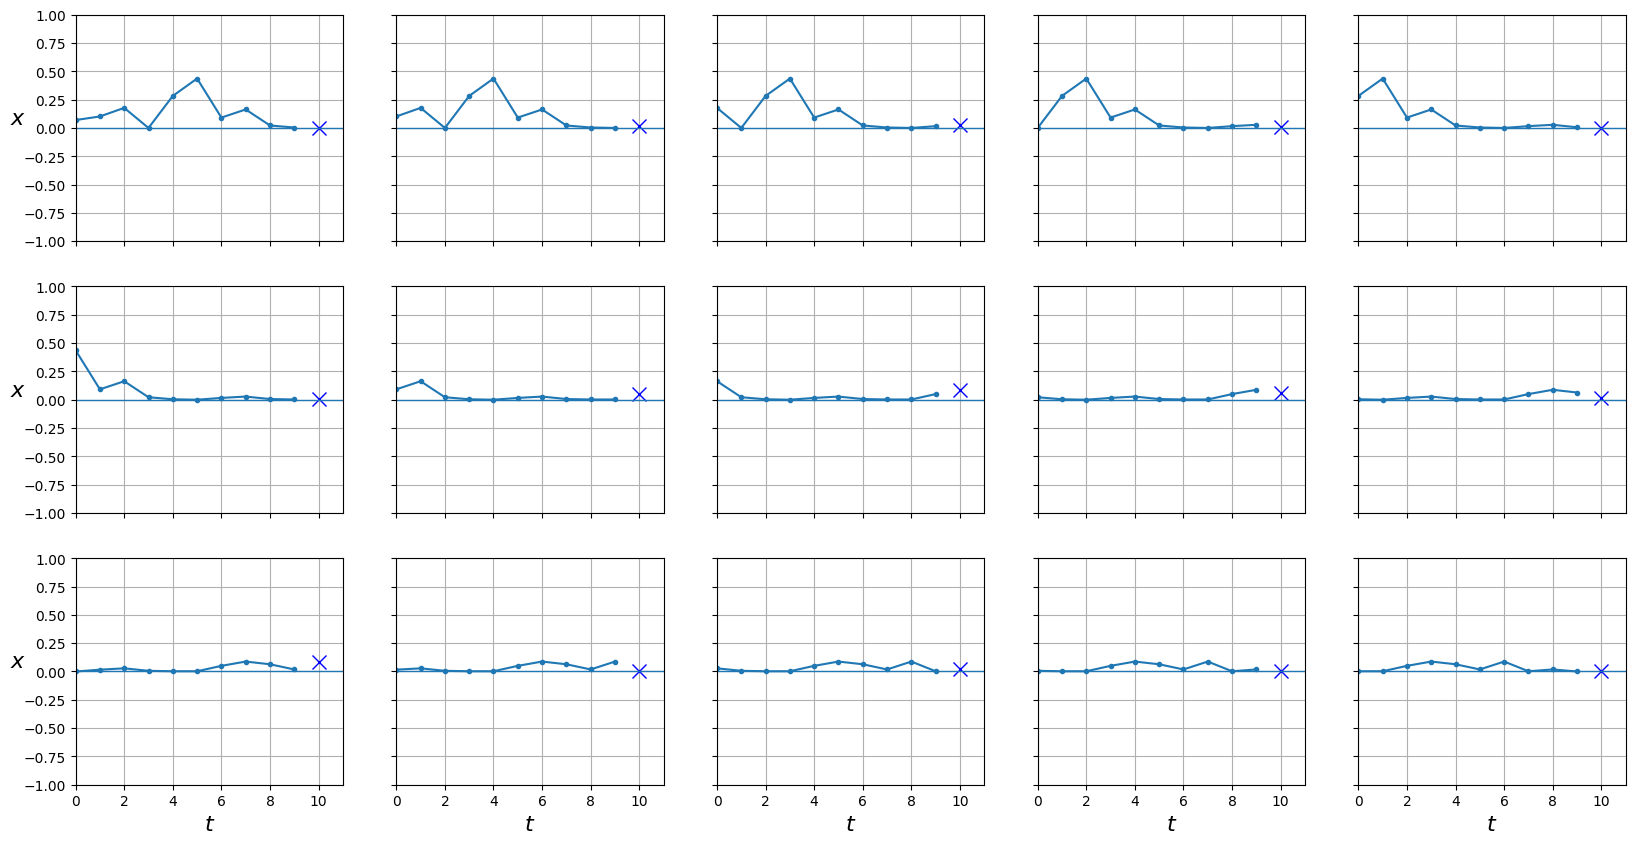

In [202]:
import matplotlib.pyplot as plt

def plot_series(series, y=None, y_pred=None, y_pred_std=None, x_label="$t$", y_label="$x$"):
  r, c = 3, 5
  fig, axes = plt.subplots(nrows=r, ncols=c, sharey=True, sharex=True, figsize=(20, 10))
  for row in range(r):
    for col in range(c):
        plt.sca(axes[row][col])
        ix = col + row*c
        plt.plot(series[ix, :], ".-")
        if y is not None:
            plt.plot(range(len(series[ix, :]), len(series[ix, :])+len(y[ix])), y[ix], "bx", markersize=10)
        if y_pred is not None:
            plt.plot(range(len(series[ix, :]), len(series[ix, :])+len(y_pred[ix])), y_pred[ix], "ro")
        if y_pred_std is not None:
            plt.plot(range(len(series[ix, :]), len(series[ix, :])+len(y_pred[ix])), y_pred[ix] + y_pred_std[ix])
            plt.plot(range(len(series[ix, :]), len(series[ix, :])+len(y_pred[ix])), y_pred[ix] - y_pred_std[ix])
        plt.grid(True)
        plt.hlines(0, 0, 100, linewidth=1)
        plt.axis([0, len(series[ix, :])+len(y[ix]), -1, 1])
        if x_label and row == r - 1:
          plt.xlabel(x_label, fontsize=16)
        if y_label and col == 0:
          plt.ylabel(y_label, fontsize=16, rotation=0)
  plt.show()

plot_series(X_test, y_test)

In [203]:
from sklearn.metrics import mean_squared_error

y_pred = X_test[:,-1]
mean_squared_error(y_test, y_pred)

0.0035560209633550065

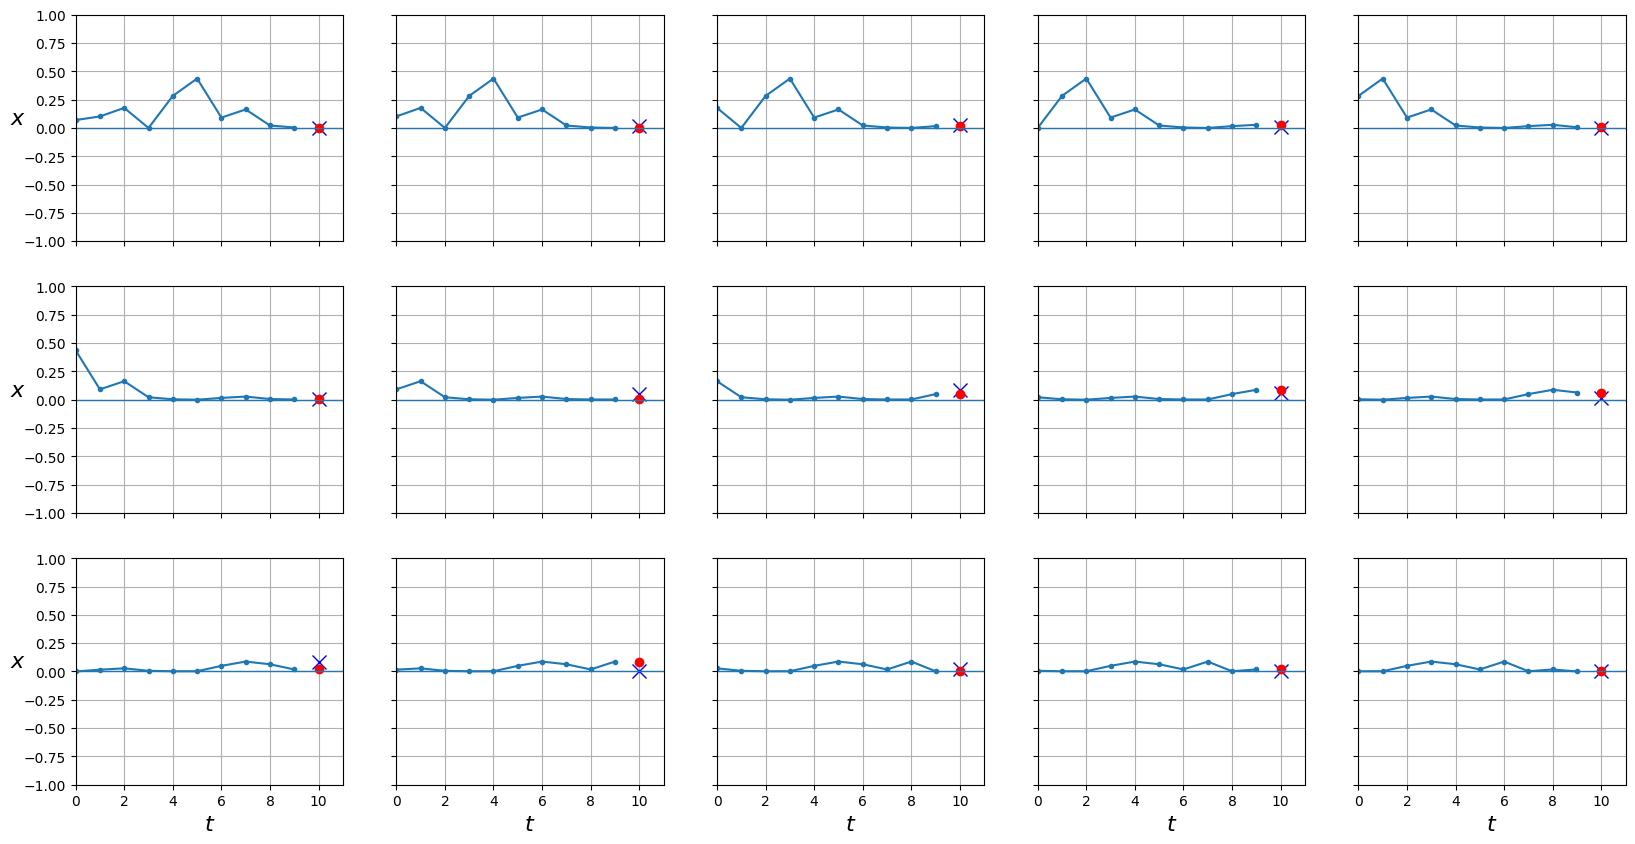

In [204]:
y_pred = X_test[:,-1]
plot_series(X_test, y_test, y_pred)

In [205]:
import torch

class SimpleRNN(torch.nn.Module):
  def __init__(self):
    super().__init__()
    self.rnn = torch.nn.RNN(input_size=1, hidden_size=1, num_layers=1, batch_first=True)

  def forward(self, x):
    x, h = self.rnn(x)
    # solo queremos la última salida
    return x[:,-1]

rnn = SimpleRNN()

In [206]:
from tqdm import tqdm
import numpy as np
import torch

device = "cuda" if torch.cuda.is_available() else "cpu"

def fit(model, dataloader, epochs=10):
    model.to(device)
    optimizer = torch.optim.Adam(model.parameters(), lr=1e-3)
    criterion = torch.nn.MSELoss()

    train_losses = []
    val_losses = []

    bar = tqdm(range(1, epochs+1))
    for epoch in bar:
        # --- Entrenamiento ---
        model.train()
        epoch_train_loss = []
        for batch in dataloader['train']:
            X, y = batch
            X, y = X.to(device), y.to(device)
            optimizer.zero_grad()
            y_hat = model(X)
            loss = criterion(y_hat, y)
            loss.backward()
            optimizer.step()
            epoch_train_loss.append(loss.item())
        train_loss_mean = np.mean(epoch_train_loss)
        train_losses.append(train_loss_mean)

        # --- Evaluación ---
        model.eval()
        epoch_val_loss = []
        with torch.no_grad():
            for batch in dataloader['eval']:
                X, y = batch
                X, y = X.to(device), y.to(device)
                y_hat = model(X)
                loss = criterion(y_hat, y)
                epoch_val_loss.append(loss.item())
        val_loss_mean = np.mean(epoch_val_loss)
        val_losses.append(val_loss_mean)

        bar.set_description(f"loss {train_loss_mean:.5f} val_loss {val_loss_mean:.5f}")

    # Retornar losses completos
    return train_losses, val_losses

def predict(model, dataloader):
    model.eval()
    with torch.no_grad():
        preds = torch.tensor([]).to(device)
        for batch in dataloader:
            # Para test dataset que no tiene y
            if isinstance(batch, (tuple, list)):
                X = batch[0]
            else:
                X = batch
            X = X.to(device)
            pred = model(X)
            preds = torch.cat([preds, pred])
        return preds # convertir a numpy para graficar


In [207]:
import torch
from torch.utils.data import Dataset, DataLoader
class TimeSeriesDataset(Dataset):
    def __init__(self, X, y=None, train=True):
        self.X = X.astype(np.float32)
        self.y = y.astype(np.float32) if y is not None else y
        self.train = train

    def __len__(self):
        return len(self.X)

    def __getitem__(self, ix):
        if self.train:
            return torch.from_numpy(self.X[ix]), torch.from_numpy(self.y[ix])
        return torch.from_numpy(self.X[ix])



In [208]:
dataset = {
    'train': TimeSeriesDataset(X_train, y_train),
    'eval': TimeSeriesDataset(X_valid, y_valid),
    'test': TimeSeriesDataset(X_test, y_test, train=False)
}

dataloader = {
    'train': DataLoader(dataset['train'], shuffle=True, batch_size=64),
    'eval': DataLoader(dataset['eval'], shuffle=False, batch_size=64),
    'test': DataLoader(dataset['test'], shuffle=False, batch_size=64)
}

loss 0.00196 val_loss nan: 100%|██████████| 20/20 [00:13<00:00,  1.52it/s]


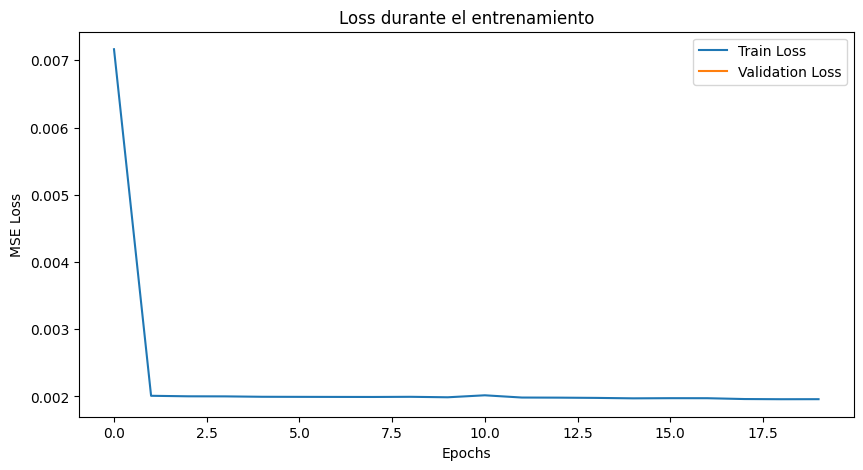

In [209]:
train_losses, val_losses = fit(rnn, dataloader, epochs=20)

# Graficar loss
import matplotlib.pyplot as plt
plt.figure(figsize=(10,5))
plt.plot(train_losses, label="Train Loss")
plt.plot(val_losses, label="Validation Loss")
plt.xlabel("Epochs")
plt.ylabel("MSE Loss")
plt.title("Loss durante el entrenamiento")
plt.legend()
plt.show()

# Predicciones sobre test
y_pred = predict(rnn, dataloader['test'])


In [210]:
class RNN(torch.nn.Module):
  def __init__(self):
    super().__init__()
    self.rnn = torch.nn.RNN(input_size=1, hidden_size=40, num_layers=1, batch_first=True)
    self.fc = torch.nn.Linear(40, 1)

  def forward(self, x):
    x, h = self.rnn(x)
    # get the last output and apply linear layer
    y = self.fc(x[:,-1])
    return y

rnn = RNN()

In [211]:
rnn.rnn.weight_hh_l0.shape, rnn.rnn.weight_ih_l0.shape, rnn.rnn.bias_hh_l0.shape, rnn.rnn.bias_ih_l0.shape, rnn.fc.weight.shape, rnn.fc.bias.shape

(torch.Size([40, 40]),
 torch.Size([40, 1]),
 torch.Size([40]),
 torch.Size([40]),
 torch.Size([1, 40]),
 torch.Size([1]))

loss 0.00195 val_loss nan: 100%|██████████| 20/20 [00:14<00:00,  1.33it/s]


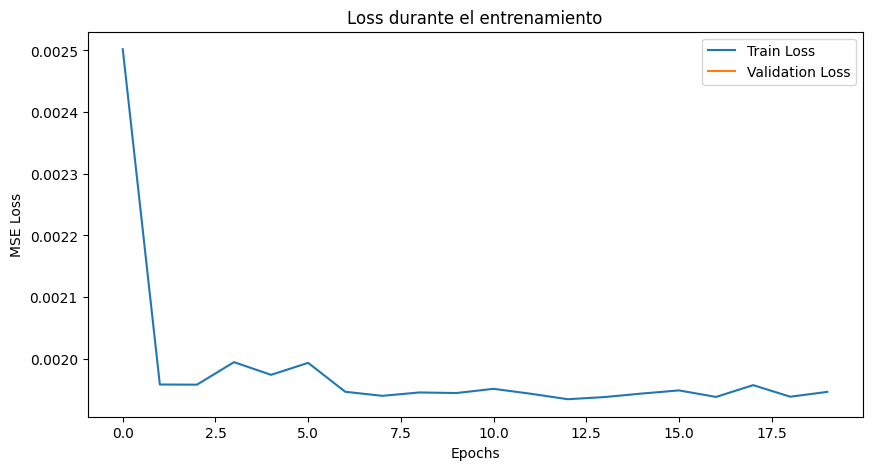

In [212]:
train_losses, val_losses = fit(rnn, dataloader, epochs=20)

# Graficar loss
import matplotlib.pyplot as plt
plt.figure(figsize=(10,5))
plt.plot(train_losses, label="Train Loss")
plt.plot(val_losses, label="Validation Loss")
plt.xlabel("Epochs")
plt.ylabel("MSE Loss")
plt.title("Loss durante el entrenamiento")
plt.legend()
plt.show()

# Predicciones sobre test
y_pred = predict(rnn, dataloader['test'])


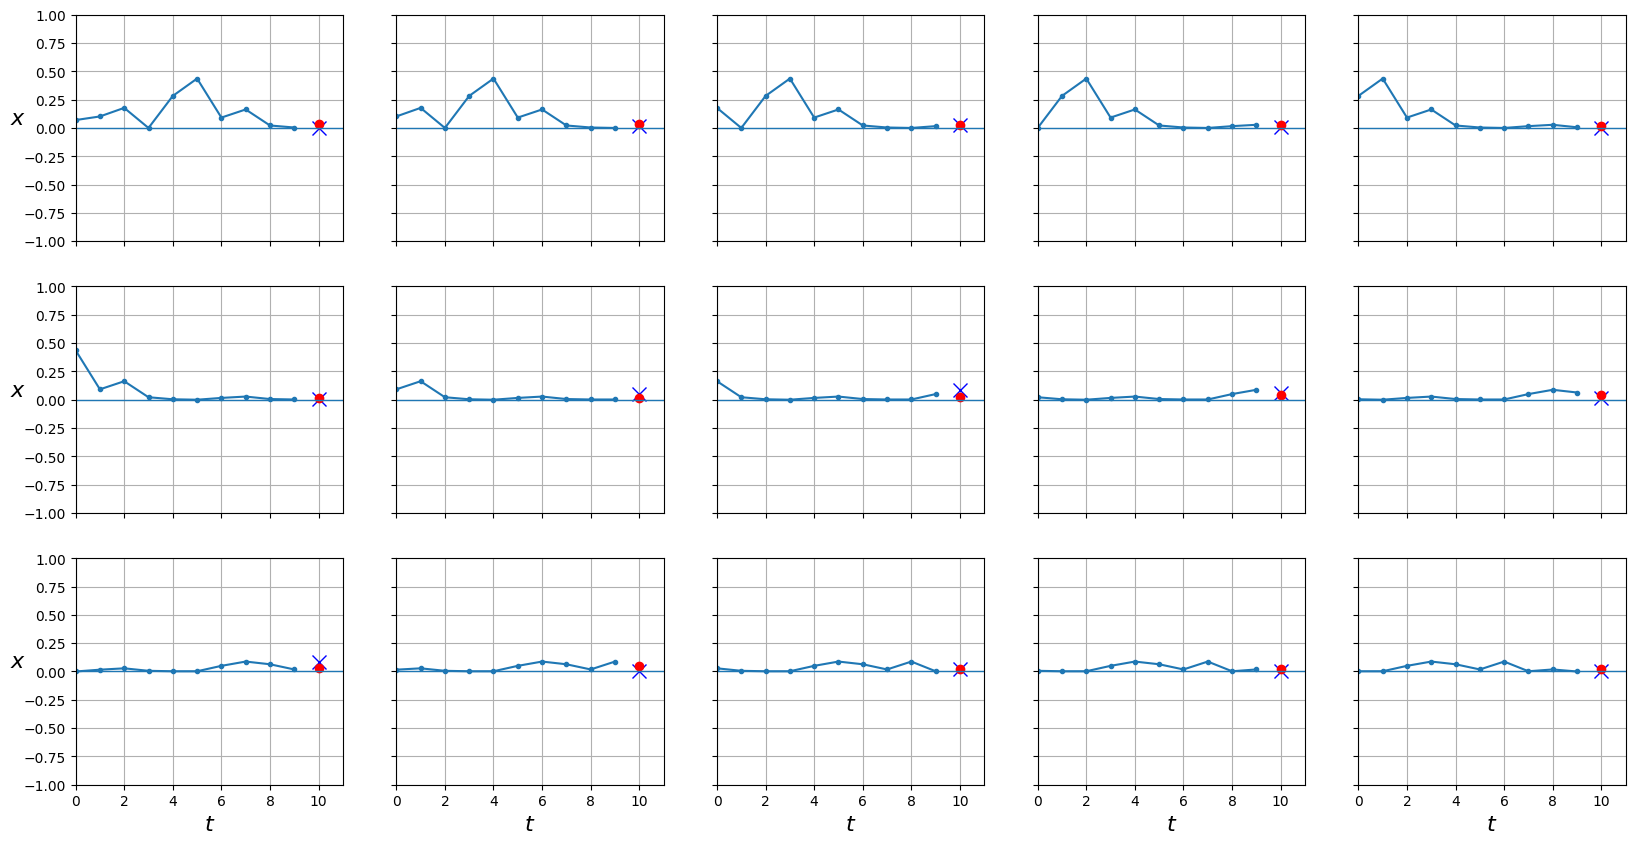

0.0023091105741170023

In [213]:
y_pred = predict(rnn, dataloader['test']).cpu().numpy()
plot_series(X_test, y_test, y_pred)
mean_squared_error(y_test, y_pred)

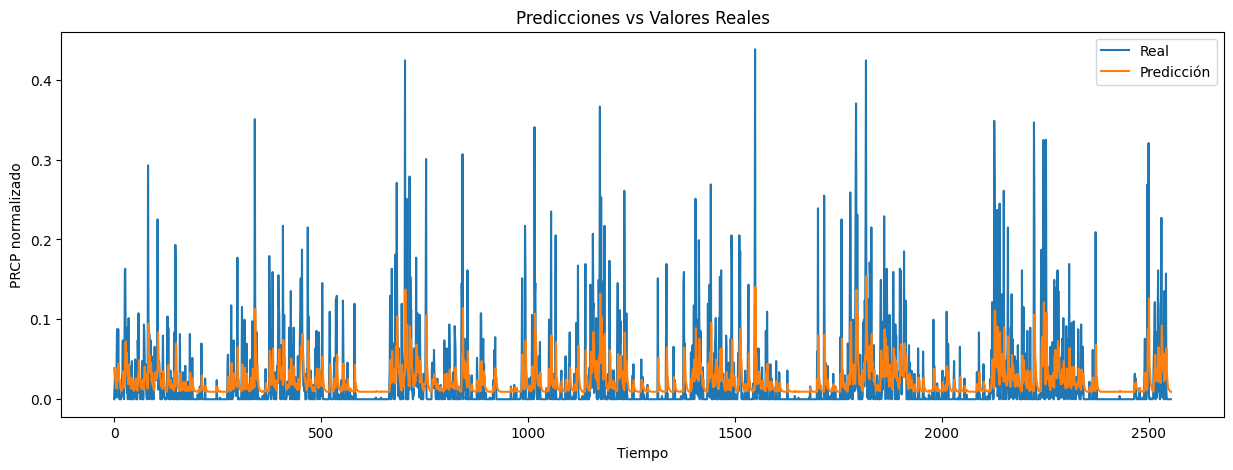

In [215]:
y_pred = predict(rnn, dataloader['test']).cpu().numpy()
y_true = y_test

plt.figure(figsize=(15,5))
plt.plot(y_true, label="Real")
plt.plot(y_pred, label="Predicción")
plt.title("Predicciones vs Valores Reales")
plt.xlabel("Tiempo")
plt.ylabel("PRCP normalizado")
plt.legend()
plt.show()

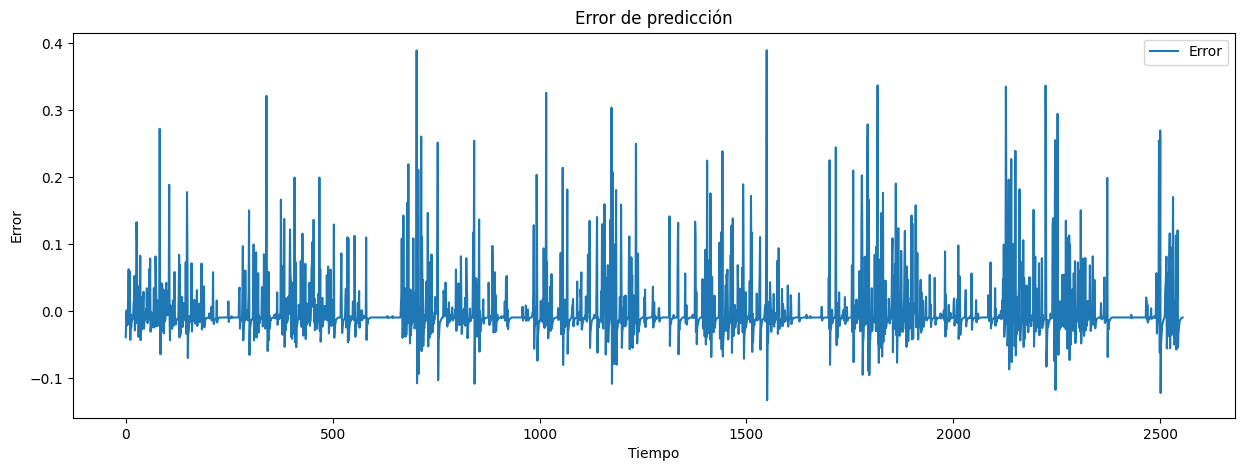

In [216]:
plt.figure(figsize=(15,5))
plt.plot(y_true - y_pred, label="Error")
plt.title("Error de predicción")
plt.xlabel("Tiempo")
plt.ylabel("Error")
plt.legend()
plt.show()